In [1]:
import numpy as np
import mne
from glob import glob
import pandas as pd
import pylab as plt
from copy import copy

# For parallel processing
import multiprocessing as mp
n_cpus = mp.cpu_count()

# For custom codebase
import sys
sys.path.insert(0, 'C:\\Users\\esolo\\Documents\\Python Scripts\\lib')

**Test w/ an example subject**

Note that the preprocessing pipeline identifies electrodes by the "channels" column, and it appears the rsfMRI data might identify them by the "Contacts" column. It seems these are almost always the same but worth being aware of. 

First approach can be to simply use the anode of every bipolar pair as the measure of connectivity. But could also envision averaging the connectivity across anode/cathode. The row index of the Contact_Correlations.csv file (plus 1) corresponds to the row index of original contacts CSV, which can then be used to derive the actual contact number (important because some contacts are skipped), and finally link that to the processed data by either the "Contacts" column or the "channel_name" column. 

In [2]:
# Set parameters
subject = '634'
source_data = './multitaper_power/multitaper_power_0.05_0.55_3-8Hz.pkl'
subroot = 'D:/'+subject+'/'
target = 'R_DLPFC'

# Load the data and exclude bad electrodes
df = pd.read_pickle(source_data) 
df = df[(df['saturated']==False) & (df['noisy']==False) & (df['Seizure_Exclude']!=1)]
df_sub = copy(df[(df['subject']==subject) & (df['target'].str.contains(target))])
fmri = pd.read_csv(subroot+subject+'_TMS-Contact_CorrelationsZ.csv')
contacts = pd.read_csv(subroot+subject+'_Contacts.csv')

# Add a column for rsfMRI values
df_sub['rsfMRI'] = ''

# Loop through contacts and assign values to each cell in the new column
for i in fmri.index:
    contact_number = contacts.iloc[i]['Contact']
    df_idx = df_sub[df_sub['Contact']==contact_number].index
    df_sub.loc[df_idx, 'rsfMRI'] = fmri[target].iloc[i]

(-0.006093143698416875, 0.9668564066516743)


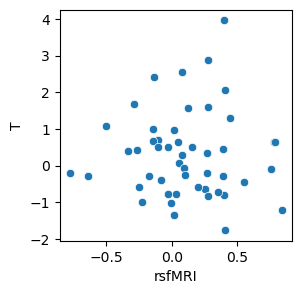

In [3]:
import pylab as plt
import seaborn as sns
from scipy.stats import pearsonr
%matplotlib inline

# Scatter plot the results (should Fisher Z transform?)
plt.figure(figsize=(3, 3)); ax=plt.subplot(111)
sns.scatterplot(data=df_sub, x='rsfMRI', y='T')
print(pearsonr(df_sub['rsfMRI'], df_sub['T']))

### Analyze across subjects

In [17]:
# Load the data
source_data = './multitaper_power/multitaper_power_0.05_0.55_3-8Hz.pkl'
df = pd.read_pickle(source_data) 
corr_dict = {}

# Exclude bad electrodes
df = df[(df['saturated']==False) & (df['noisy']==False) & (df['Seizure_Exclude']!=1)]

# Get all subjects
all_subjects = df['subject'].unique()

# Containers for responders vs. non-responders
responders = []
non_responders = []

# Loop through all subjects and process fMRI connectivity vs. T-stat correlations
for subject in all_subjects: 

    try:
        subroot = 'D:/'+subject+'/'
        fmri = pd.read_csv(subroot+subject+'_TMS-Contact_CorrelationsZ.csv')  # Load the fMRI data
        contacts = pd.read_csv(subroot+subject+'_Contacts.csv')  # Load the contacts data
        df_sub = df[df['subject']==subject]   # Identify subject data within the database
    except:
        continue
    
    for target in df_sub['target'].unique():
            
        df_sub_targ = copy(df_sub[df_sub['target']==target])  # Identify data for a specific TMS target
        
        # Add a column for rsfMRI values
        df_sub_targ['rsfMRI'] = ''
        dists = np.array(df_sub_targ['target_distance'])

        # Loop through contacts and assign values to each cell in the new column
        try:
            for i in fmri.index:
                contact_number = contacts.iloc[i]['Contact']
                df_idx = df_sub_targ[df_sub_targ['Contact']==contact_number].index
                df_sub_targ.loc[df_idx, 'rsfMRI'] = fmri[target].iloc[i]
        except:
            continue
            
        # Regress out the effect of distance
        try:
            from sklearn.linear_model import LinearRegression
            model = LinearRegression()
            Ts_ = df_sub_targ['T']
            model.fit(dists.reshape(-1, 1), Ts_)
            Ts_predict = model.predict(dists.reshape(-1, 1))
            Ts_resid = Ts_-Ts_predict
        except:
            print('Subject '+subject+' has no computed distances.')
            continue
        
        # Compute Pearson correlation and save the data
        r, p = pearsonr(df_sub_targ['rsfMRI'], Ts_resid)
        corr_dict[subject+'_'+target] = (r, p)
        
        # Average rsfMRI values for electrodes w/ significant response
        responders.append(np.mean(df_sub_targ[(Ts_resid>2)]['rsfMRI']))
        non_responders.append(np.mean(df_sub_targ[(Ts_resid<1) & (Ts_resid>-1)]['rsfMRI']))
        
        # Save results
        #df_sub_targ.to_csv('D:/'+subject+'/fMRI_connectivity_'+subject+'_'+target+'_0.05_0.55_3-8Hz.csv')
        
responders, non_responders = np.array(responders), np.array(non_responders)

Subject 634 has no computed distances.
Subject 622 has no computed distances.


Ttest_1sampResult(statistic=-0.4720529345805173, pvalue=0.6419986646099527)


(array([2., 2., 1., 1., 2., 3., 2., 3., 2., 3.]),
 array([-0.12930111, -0.10578604, -0.08227096, -0.05875589, -0.03524081,
        -0.01172574,  0.01178934,  0.03530441,  0.05881949,  0.08233456,
         0.10584964]),
 <BarContainer object of 10 artists>)

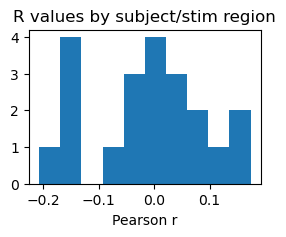

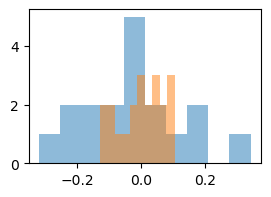

In [18]:
# Plot results
r_ = [a[0] for a in corr_dict.values()]
plt.figure(figsize=(3, 2)); ax=plt.subplot(111)
plt.hist(r_)
plt.title('R values by subject/stim region')
plt.xlabel('Pearson r')

from scipy.stats import ttest_1samp
print(ttest_1samp(r_, 0))

plt.figure(figsize=(3, 2)); ax=plt.subplot(111)
plt.hist(responders, alpha=0.5); plt.hist(non_responders, alpha=0.5)

Ttest_1sampResult(statistic=-0.4720529345805173, pvalue=0.6419986646099527)


Ttest_indResult(statistic=-0.5765762624389089, pvalue=0.567717128067047)

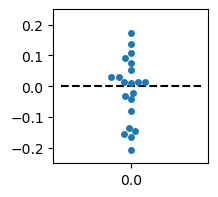

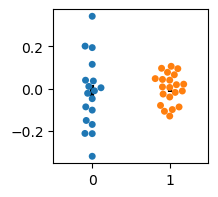

In [23]:
from scipy.stats import sem
from scipy.stats import ttest_rel

plt.figure(figsize=(2, 2)); ax=plt.subplot(111)
sns.swarmplot(x=np.zeros(len(r_)), y=r_)
plt.hlines([0], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linestyle='--', color='k')
plt.ylim(-0.25, 0.25)
print(ttest_1samp(r_, 0))
plt.savefig('./multitaper_epo_plots/fMRI_correlations_theta_0-500ms.pdf')

plt.figure(figsize=(2, 2)); ax=plt.subplot(111)
toplot = [responders[np.isfinite(responders)], non_responders[np.isfinite(non_responders)]]
plt.errorbar(x=[0, 1], y=[np.mean(toplot[0]), np.mean(toplot[1])], yerr=[sem(toplot[0]), sem(toplot[1])], 
            linewidth=1, linestyle='None', capsize=0, ecolor='k', elinewidth=3,)
sns.swarmplot(data=toplot)
plt.savefig('./multitaper_epo_plots/fMRI_responder_nonresponder_theta_0-500ms.pdf')

from scipy.stats import ttest_ind
ttest_ind(responders[np.isfinite(responders)], non_responders[np.isfinite(non_responders)])  #ideally would use ttest_rel if data is available for all subjects

In [26]:
## Plot example rsfMRI matrix from subject 622 (data available)
adj = np.loadtxt('D:/622/622_Contact_Correlation_Matrix.csv', delimiter=',', dtype='float')

<Figure size 640x480 with 0 Axes>

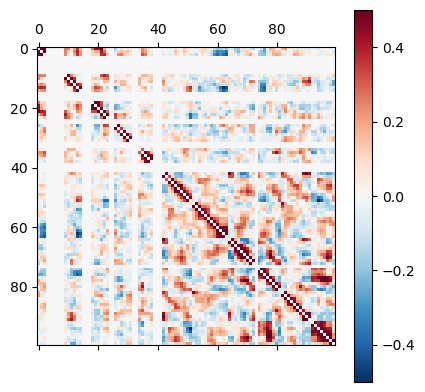

In [36]:
plt.figure()
plt.matshow(adj, cmap='RdBu_r', vmin=-0.5, vmax=0.5)
plt.colorbar()
plt.savefig('./multitaper_epo_plots/622_sample_fMRI_adjacency.pdf')